#### Import Libraries

In [1]:
import os
from random import sample
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from matplotlib import gridspec
from StructureDataModule import structure_data

In [2]:
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from keras.initializers import GlorotNormal, GlorotUniform
from keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array

#### Structuring data files

In [3]:
structure_data()

Files moved succesfully!


#### Image Preprocessing

In [4]:
trainset_path = './input/train_set'
valset_path = './input/validation_set'
testset_path = './input/test_set'

(384, 512, 3)


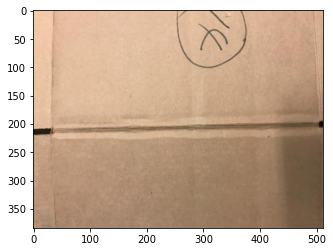

In [5]:
test_img = plt.imread('./input/train_set/cardboard/cardboard1.jpg')
print(test_img.shape)
plt.imshow(test_img)

In [6]:
train_datagen = ImageDataGenerator(
    rescale = 1/255.,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

train_generator = train_datagen.flow_from_directory(
    trainset_path,
    target_size = (64, 64),
    batch_size = 32,
    class_mode = 'categorical'
)

Found 1768 images belonging to 6 classes.


In [7]:
train_generator.class_indices

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

In [8]:
val_datagen = ImageDataGenerator(
    rescale = 1/255.
)

val_generator = val_datagen.flow_from_directory(
    valset_path,
    target_size = (64, 64),
    batch_size = 32,
    class_mode = 'categorical'
)

Found 328 images belonging to 6 classes.


### Auxiliary Functions

In [9]:
def setModelResults():
    #Get model ID
    with open('./models/model_results.csv') as file:
        lines = file.readlines()  
    model_id = len(lines)
            
    #Prepare directory
    path = './models/' + 'cnn_model{}'.format(model_id)
    if not os.path.exists(path):
        os.makedirs(path)       
        
    return model_id

In [10]:
def writeModelResults(results, model):
    results.to_csv('./results/model_results.csv', mode = 'a', header = False, index = False)
    print('Model results saved succesfully')
    return 

### CNN Model

In [11]:
model_id = setModelResults()
model_id

1

##### Callbacks

In [12]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > 0.85):
            print("\nReached 85% accuracy so cancelling training!")
            self.model.stop_training = True

In [13]:
stop_cb = myCallback()

In [14]:
checkpoint_path = './models/cnn_model{}/weights_cp.ckpt'.format(model_id)

In [15]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 monitor='val_accuracy',
                                                 save_best_only = True,
                                                 verbose=1)

##### Model

In [16]:
model = Sequential([
     Conv2D(filters = 256, kernel_size = (3,3), input_shape = (64,64,3), activation = 'relu', kernel_initializer = GlorotUniform())
    ,MaxPool2D(pool_size = (2,2))
    ,Conv2D(filters = 256, kernel_size = (3,3), activation = 'relu', kernel_initializer = GlorotUniform())
    ,MaxPool2D(pool_size = (2,2))
    ,Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu', kernel_initializer = GlorotUniform())
    ,MaxPool2D(pool_size = (2,2))
    ,Flatten()
    ,Dense(units = 512, activation = 'relu', kernel_initializer = GlorotUniform())
    ,Dropout(0.3)
    ,Dense(units = 128, activation = 'relu', kernel_initializer = GlorotUniform())
    ,Dropout(0.3)
    ,Dense(units = 6, activation = 'softmax')
])

In [17]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [18]:
model_path = './models/cnn_model{}/cnn_model.h5'.format(model_id)
model.save(model_path)

In [19]:
%%time
history = model.fit(
     x = train_generator
    ,epochs = 50
    ,validation_data = val_generator
    ,callbacks = [stop_cb, cp_callback]
)

Epoch 1/20
56/56 [==============================] - 28s 149ms/step - loss: 1.7433 - accuracy: 0.2132 - val_loss: 1.8519 - val_accuracy: 0.2530

Epoch 00001: val_accuracy improved from -inf to 0.25305, saving model to ./models/cnn_model1\weights_cp.ckpt
Epoch 2/20
56/56 [==============================] - 7s 129ms/step - loss: 1.5925 - accuracy: 0.3428 - val_loss: 1.5270 - val_accuracy: 0.3232

Epoch 00002: val_accuracy improved from 0.25305 to 0.32317, saving model to ./models/cnn_model1\weights_cp.ckpt
Epoch 3/20
56/56 [==============================] - 7s 132ms/step - loss: 1.4225 - accuracy: 0.4202 - val_loss: 1.3257 - val_accuracy: 0.4573

Epoch 00003: val_accuracy improved from 0.32317 to 0.45732, saving model to ./models/cnn_model1\weights_cp.ckpt
Epoch 4/20
56/56 [==============================] - 7s 132ms/step - loss: 1.3624 - accuracy: 0.4548 - val_loss: 1.4542 - val_accuracy: 0.4146

Epoch 00004: val_accuracy did not improve from 0.45732
Epoch 5/20
56/56 [=====================

##### Evaluate training results

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 256)       7168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 256)       590080    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       295040    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0

In [21]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0.5, 0, 'epoch')

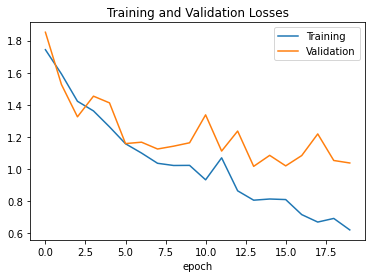

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation Losses')
plt.xlabel('epoch')

#### Predictions

In [24]:
test_datagen = ImageDataGenerator(
    rescale = 1/255.
)

test_generator = test_datagen.flow_from_directory(
    testset_path,
    target_size = (64, 64),
    batch_size = 32,
    class_mode = 'categorical'
)

Found 431 images belonging to 6 classes.


In [25]:
test_loss, test_acc = model.evaluate(test_generator)
print('Test loss: {} Test Acc: {}'.format(test_loss, test_acc))

14/14 [==============================] - 1s 100ms/step - loss: 0.9671 - accuracy: 0.6566
Test loss: 0.9670764803886414 Test Acc: 0.6566125154495239


### Save model results

In [26]:
results = pd.DataFrame({'Model_ID': model_id, 'Model_path': model_path, 'Weights_path': checkpoint_path, 'Accuracy': test_acc}, index = [0])
results

,Model_ID,Model_path,Weights_path,Accuracy
0,1,./models/cnn_model1/cnn_model.h5,./models/cnn_model1/weights_cp.ckpt,0.656613


In [27]:
results.to_csv('./models/model_results.csv', mode = 'a', header = False, index = False)

#### Plotting ConvLayers Activations

In [28]:
def getImgSamples(path, n = 1):
    imgs = dict()
    for img_class in os.listdir(path):
        class_path = os.path.join(path, img_class)
        imgs[img_class]  = sample(os.listdir(class_path), n)
    
    return imgs

In [29]:
def plotSampleImgs(imgs):
    fig, axs = plt.subplots(nrows = 1, ncols = 6, figsize = (24,24))
    col = 0
    for img_class, img_name in imgs.items():
        img_path = os.path.join(testset_path, img_class, img_name[0])
        img = load_img(img_path, target_size = (128,128))
        axs[col].imshow(img)
        axs[col].set_title('{}'.format(img_class))
        col += 1
        
    plt.subplots_adjust(wspace=1.3, hspace=1.3)
    plt.show()
    return

In [30]:
sample_imgs = getImgSamples(testset_path, 1)
sample_imgs

{'cardboard': ['cardboard313.jpg'],
 'glass': ['glass135.jpg'],
 'metal': ['metal328.jpg'],
 'paper': ['paper114.jpg'],
 'plastic': ['plastic438.jpg'],
 'trash': ['trash93.jpg']}

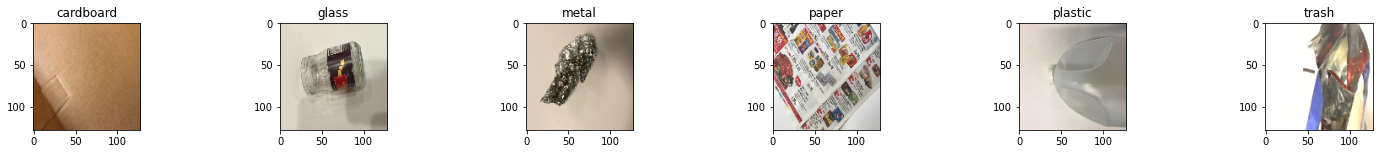

In [31]:
plotSampleImgs(sample_imgs)

In [32]:
def plotFeaturesMaps(model, path, img_class, imgs):

    #Get convolution and pooling layers to plot
    names = [layer.name for layer in model.layers if ('conv' in layer.name)]
    outputs = [layer.output for layer in model.layers if ('conv' in layer.name)]
    
    # redefine model to output right after the first hidden layer
    feature_map_model = Model(inputs = model.inputs, outputs = outputs)
    
    #Get and prepare the image
    img_path = os.path.join(path, img_class, imgs[img_class][0])
    img = load_img(img_path, target_size=(64,64))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.
    
    #Get feature maps(activations)
    feature_maps = feature_map_model.predict(img)
    
    for layer_name, feature_map in zip(names, feature_maps):    
        k = feature_map.shape[-1] #number of filters applied on the layer
        nrow = k//8
        ncol = 8
        
        fig = plt.figure(figsize=(ncol+1, nrow+1)) 
        gs = gridspec.GridSpec(nrow, ncol,
                 wspace=0.0, hspace=0.0, 
                 top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1), 
                 left=0.5/(ncol+1), right=1-0.5/(ncol+1))  

        for i in range(nrow):
            for j in range(ncol):
                feature_img = feature_map[0, :, :, i]
                ax = plt.subplot(gs[i,j])
                ax.imshow(feature_img)
                ax.set_xticks([])
                ax.set_yticks([])

        #gs.title('Layer {}: {}'.format(i, layer_name))     
        print('Layer {}: {}'.format(i, layer_name)) 
        plt.show()
            
    return

Layer 31: conv2d


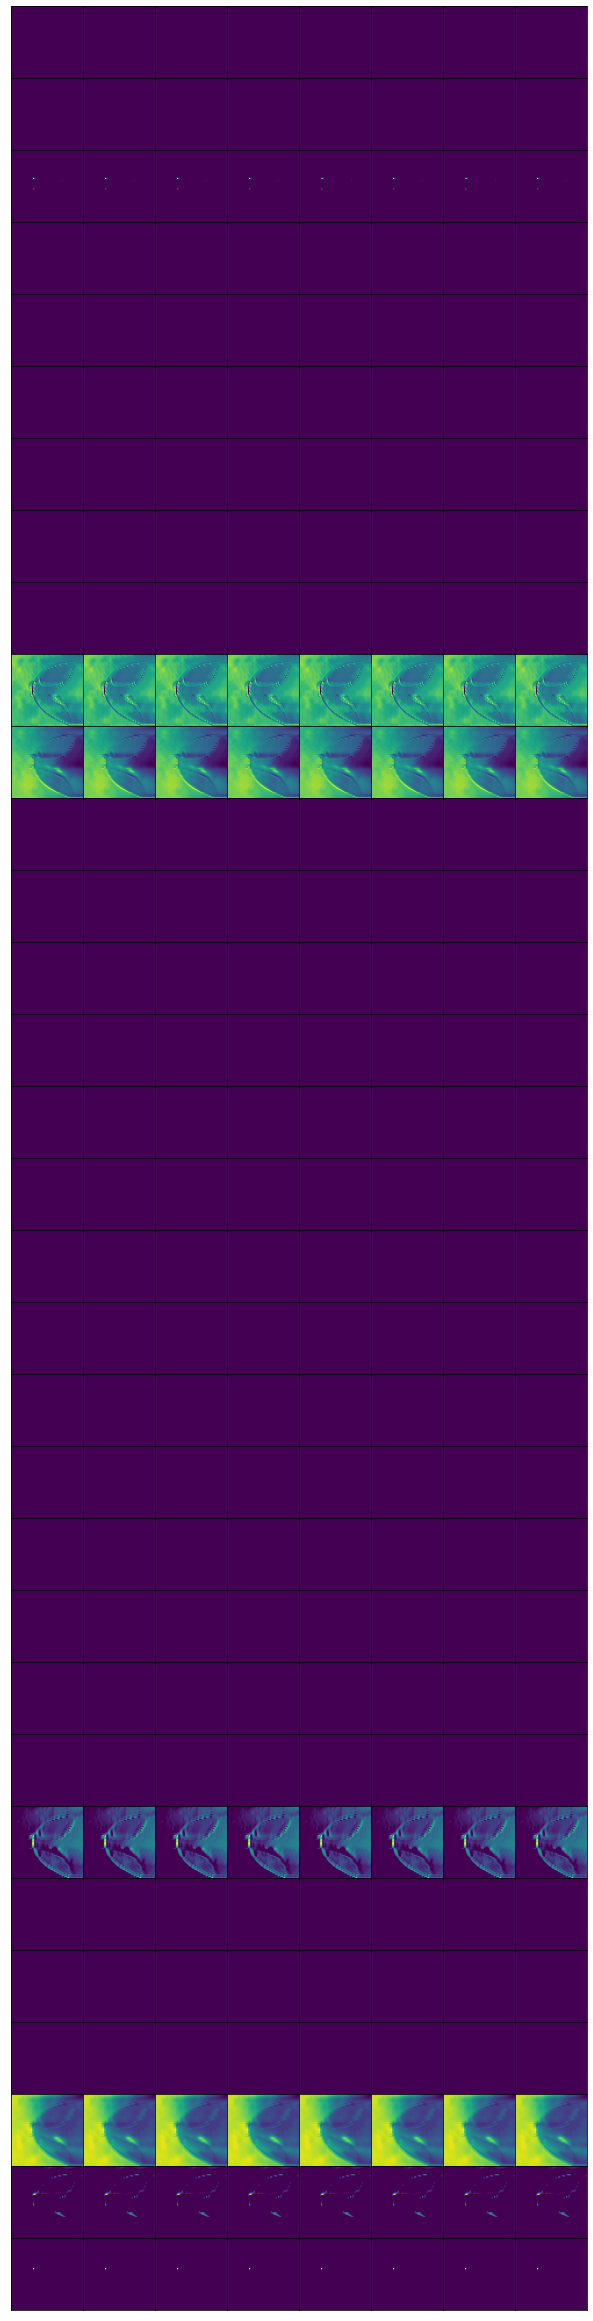

Layer 31: conv2d_1


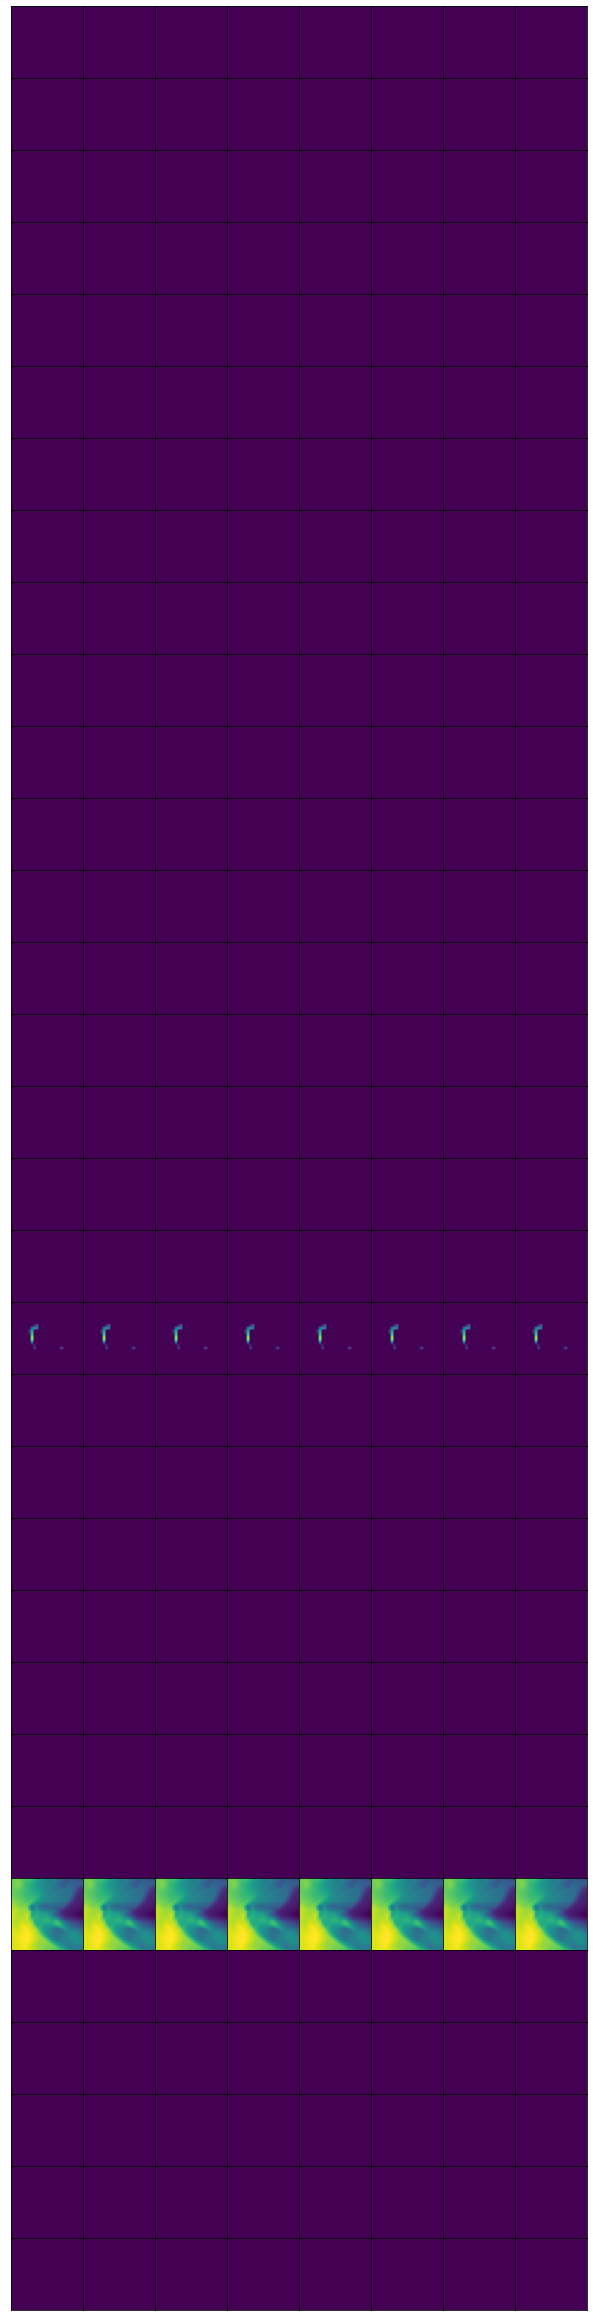

Layer 15: conv2d_2


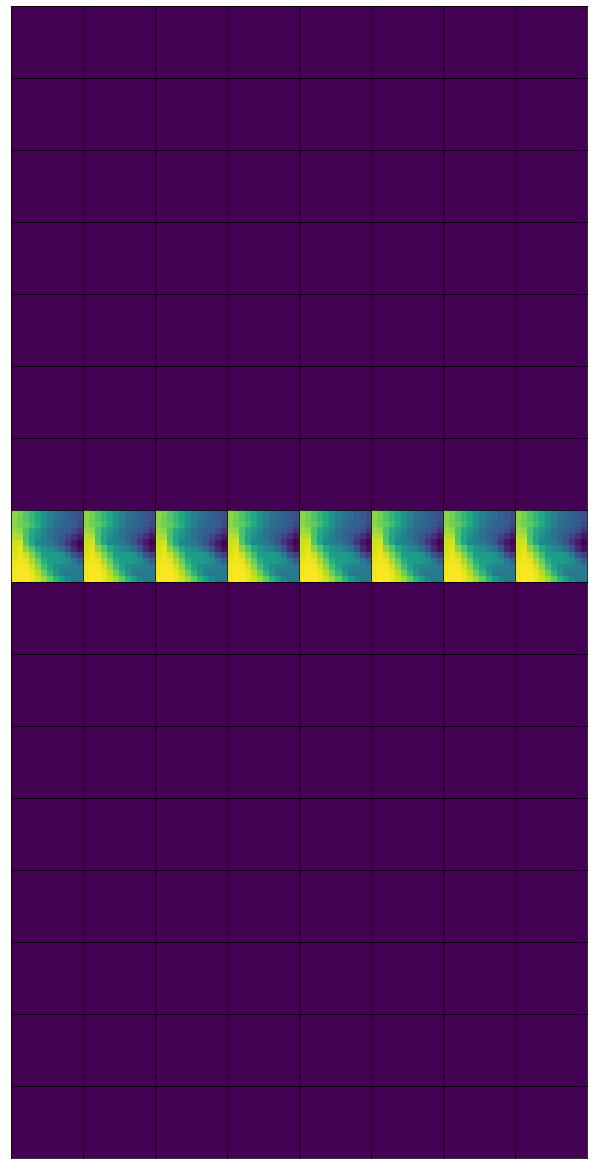

In [33]:
plotFeaturesMaps(model, testset_path, 'plastic', sample_imgs)